In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from serenityff.charge.tree.atom_features import AtomFeatures
from rdkit import Chem
import torch
import sys
from custom_featurization_stuff import get_graph_from_mol
allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]
from sklearn.model_selection import train_test_split
#also add r2
from sklearn.metrics import r2_score
#also add pearson
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
#start with loading the data
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

# Function to read SDF file and extract properties
def read_sdf(file_path):
    suppl = Chem.SDMolSupplier(file_path)
    data = []
    for mol in suppl:
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            logP = mol.GetProp('LogP') if mol.HasProp('LogP') else None
            logVP = mol.GetProp('LogVP') if mol.HasProp('LogVP') else None
            data.append({'SMILES': smiles, 'logP': logP, 'logVP': logVP})
    return data

# File paths for your SDF files
vp_path = 'OPERA_Data/VP_QR.sdf'
logp_path = 'OPERA_Data/LogP_QR.sdf'

# Read SDF files and extract data
data_vp = read_sdf(vp_path)
data_logp = read_sdf(logp_path)

# Create Pandas dataframes
df_vp = pd.DataFrame(data_vp)
df_logp = pd.DataFrame(data_logp)

#get the smiles for both
smiles_vp = df_vp['SMILES'].tolist()
smiles_logp = df_logp['SMILES'].tolist()
#get combined smiles
smiles_all = smiles_vp + smiles_logp
smiles_all = [s for s in smiles_all if s is not None]
smiles_all = list(set(smiles_all))
#foreach smile in overlap, get the logP from df2 and the logVP from df1
logP = []
logVP = []
for smile in smiles_all:
    #append val or 0.0 if not found
    logP.append(df_logp[df_logp['SMILES'] == smile]['logP'].values[0] if smile in smiles_logp else np.nan)
    logVP.append(df_vp[df_vp['SMILES'] == smile]['logVP'].values[0] if smile in smiles_vp else np.nan)
    
#make a new dataframe
df = pd.DataFrame({'SMILES': smiles_all, 'logP': logP, 'logVP': logVP})
df



[10:14:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[10:14:07] ERROR: Could not sanitize molecule ending on line 38202
[10:14:07] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27


,SMILES,logP,logVP
0,Clc1ccc(Oc2ccccc2)c(Cl)c1,4.93,-3.0355515689960866
1,CC(C)(CCC(=O)O)C(=O)O,0.67,NaN
2,COCC(F)(F)C(F)C(F)(F)F,NaN,1.7852999317382818
3,CS(=O)(=O)F,0.55,1.0373986065737049
4,Cn1c([N+](=O)[O-])cnc1C=Cc1ccnc(N)n1,0.85,NaN
...,...,...,...
15075,CCN(CC)CCOC(=O)C=Cc1cc(OC)c(OC)c(OC)c1,2.84,NaN
15076,CCOCCCNc1ncnc2c1ncn2C1OC(CO)C(O)C1O,0.22,NaN
15077,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,NaN,-2.5391006544969796
15078,COc1cc(CCN)cc(OC)c1OC,0.78,NaN


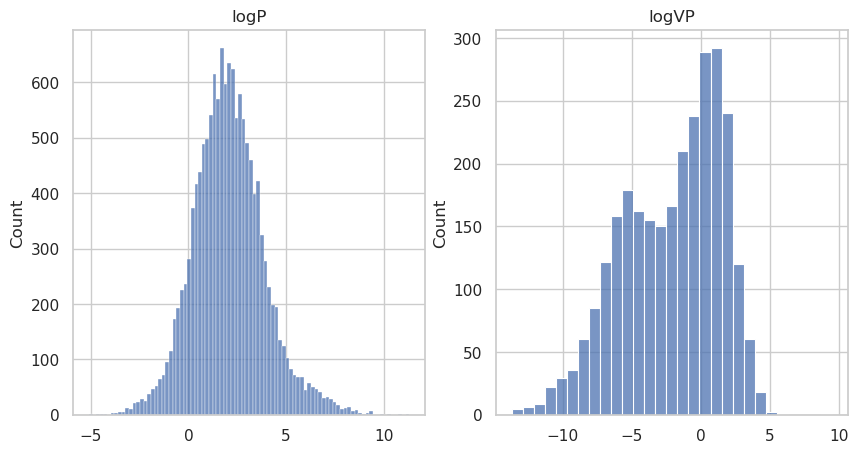

In [3]:
#do histograms of the logps and vps
df['logP'] = df['logP'].astype(float)
df['logVP'] = df['logVP'].astype(float)
logp_vals = df['logP'].tolist()
vp_vals = df['logVP'].tolist()
# logp_vals = [x for x in logp_vals if x != 0.0]
# vp_vals = [x for x in vp_vals if x != 0.0]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(logp_vals, ax=ax[0])
ax[0].set_title('logP')
sns.histplot(vp_vals, ax=ax[1])
ax[1].set_title('logVP')
plt.show()


In [4]:
# tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

In [5]:
# all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
# mols = [m for m in all_mols if m.GetNumAtoms() > 1]
# error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
# mols_with_charges = []
# error_mols_charges = []
# for m in tqdm(mols):
#     try:
#         mol = Chem.AddHs(m, addCoords=True)
#         charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
#     except:
#         error_mols_charges.append(m)
#         continue
#     for i,atom in enumerate(mol.GetAtoms()):
#         atom.SetDoubleProp('charge',charges[i])
#     mols_with_charges.append(mol)


In [6]:
all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
# indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
# indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
# print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))

In [7]:
# if indices_to_drop_total:
#     print('Caution! Mols dropped')
#     df = df.drop(indices_to_drop_total)
if indices_to_drop_size:
    print('Caution! Mols dropped')
    df = df.drop(indices_to_drop_size)

Caution! Mols dropped


In [8]:
#set values of second two columns as floats
df['logP'] = df['logP'].astype(float)
df['logVP'] = df['logVP'].astype(float)


In [13]:
ys_logp = df['logP'].values
ys_vp = df['logVP'].values

In [14]:
from sklearn.preprocessing import MinMaxScaler
ys_logp = ys_logp.reshape(-1, 1)
ys_vp = ys_vp.reshape(-1, 1)
min_max_scaler_logp = MinMaxScaler()
min_max_scaler_vp = MinMaxScaler()
ys_logp = min_max_scaler_logp.fit_transform(ys_logp).flatten()
ys_vp = min_max_scaler_vp.fit_transform(ys_vp).flatten()
ys = np.column_stack((ys_logp, ys_vp))
y = torch.tensor(ys, dtype=torch.float32)
y = y.unsqueeze(1)


In [15]:
assert len(mols) == len(y)
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols)]
for i in range(len(data)):
    data[i].y = y[i]

In [16]:
from torch_geometric.loader import DataLoader
torch.cuda.empty_cache()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
#split train in train and val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)
# #datloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [30]:
#basics
import os
from math import sqrt
import pandas
import numpy as np
import random


#torch stuff
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch_geometric.nn.models import AttentiveFP



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

def train_multi(train_loader, model, optimizer, device, outputs):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            mask = torch.isnan(y_tmp) == False
            mask = mask.view(-1)
            num_labels += len(mask)
            if len(mask) > 0:
                out_tmp_present = out_tmp[mask]
                y_tmp_present = y_tmp[mask]
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(mask)

        weighted_loss = weighted_loss / num_labels
        weighted_loss.backward()

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        optimizer.step()
        del data

    return sqrt(total_loss / total_examples)


def validate_multi(val_loader, model, outputs):
    total_loss = total_examples = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            mask = torch.isnan(y_tmp) == False
            mask = mask.view(-1)
            num_labels += len(mask)
            if len(mask) > 0:
                out_tmp_present = out_tmp[mask]
                y_tmp_present = y_tmp[mask]
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(mask)


        weighted_loss = weighted_loss / num_labels

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs, outputs, verbose=True):
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)

    min_val_los = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_multi(train_loader, model, optimizer, device, outputs)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_multi(val_loader, model, outputs)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
            torch.save(model.state_dict(), 'test_model.pt')

        else:
            counter += 1
        if counter > 15:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [18]:

torch.cuda.empty_cache()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
#split train in train and val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)
# #datloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [31]:
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=2,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=2, verbose=True)

/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: Train Loss: 0.1254, Val Loss: 0.0754
Epoch 2/100: Train Loss: 0.0801, Val Loss: 0.0634
Epoch 3/100: Train Loss: 0.0715, Val Loss: 0.0756
Epoch 4/100: Train Loss: 0.0665, Val Loss: 0.0678
Epoch 5/100: Train Loss: 0.0691, Val Loss: 0.0644
Epoch 6/100: Train Loss: 0.0644, Val Loss: 0.0685
Epoch 7/100: Train Loss: 0.0639, Val Loss: 0.0583
Epoch 8/100: Train Loss: 0.0635, Val Loss: 0.0564
Epoch 9/100: Train Loss: 0.0631, Val Loss: 0.0683
Epoch 10/100: Train Loss: 0.0637, Val Loss: 0.0554
Epoch 11/100: Train Loss: 0.0627, Val Loss: 0.0594
Epoch 12/100: Train Loss: 0.0618, Val Loss: 0.0588
Epoch 13/100: Train Loss: 0.0621, Val Loss: 0.0605
Epoch 14/100: Train Loss: 0.0623, Val Loss: 0.0566
Epoch 15/100: Train Loss: 0.0613, Val Loss: 0.0564
Epoch 16/100: Train Loss: 0.0626, Val Loss: 0.0625
Epoch 17/100: Train Loss: 0.0604, Val Loss: 0.0584
Epoch 18/100: Train Loss: 0.0612, Val Loss: 0.0579
Epoch 19/100: Train Loss: 0.0602, Val Loss: 0.0555
Epoch 20/100: Train Loss: 0.0598, Val Lo

In [32]:
from scipy.stats import spearmanr,kendalltau
def get_preds_per_task(val_loader, model, outputs):
    preds = tuple([[] for i in range(outputs)])
    ys = tuple([[] for i in range(outputs)])
    counter = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]

            mask = torch.isnan(y_tmp) == False
            mask = mask.view(-1)
            if len(mask) > 0:
                out_tmp_present = out_tmp[mask].cpu().detach().numpy()
                y_tmp_present = y_tmp[mask].cpu().detach().numpy()
                counter += len(y_tmp_present)
                preds[i].extend(out_tmp_present)  
                ys[i].extend(y_tmp_present)
    print(counter)
    return preds,ys


def get_stats(out_list,y_list):
    kendall_tau = kendalltau(y_list, out_list)[0]
    rmse_overall = np.sqrt(np.mean((np.array(y_list) - np.array(out_list)) ** 2))
    mae_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)))
    within_03_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 0.3)
    within_1_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 1)

    return kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall



3353
Pearson: 0.8861164985910371
R2: 0.7845323362466601
kendall_tau: 0.7086548069938696
rmse_overall: 0.8689441145055485
mae_overall: 0.6293875937129434
within_03_overall: 0.3514780100937275
within_1_overall: 0.7999279019466474


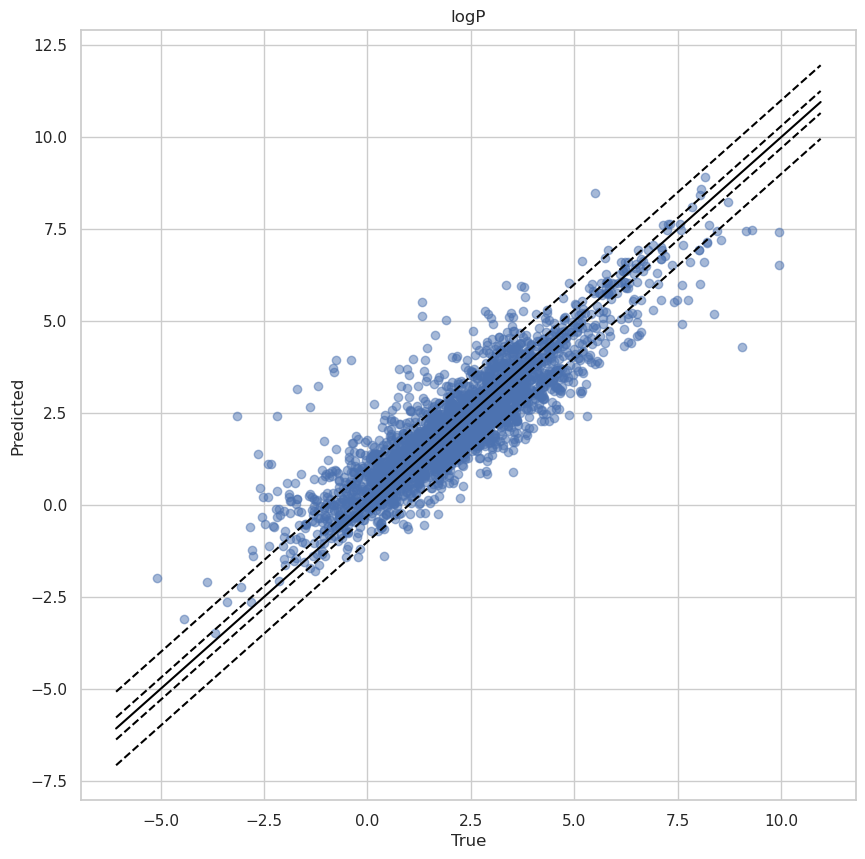

Pearson: 0.9575063703987865
R2: 0.9137926227936736
kendall_tau: 0.8376065822016815
rmse_overall: 1.027886114664306
mae_overall: 0.7596453502663221
within_03_overall: 0.3298791018998273
within_1_overall: 0.7184801381692574


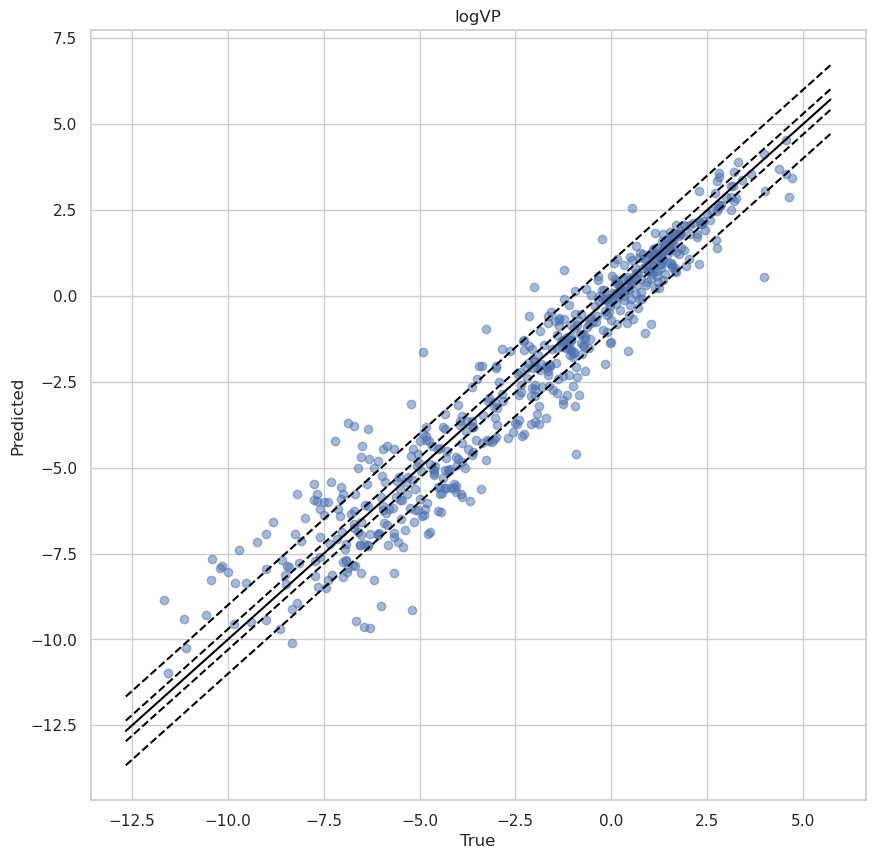

In [33]:
#not plot the outputs in same way, but for each task (colored)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
preds,ys = get_preds_per_task(test_loader, model, 2)
#get the names of the columns
column_names = df.columns[-2:]
#change from tupple to list
preds = list(preds)
ys = list(ys)
#scale back
preds[0] = min_max_scaler_logp.inverse_transform(np.array(preds[0]).reshape(-1,1)).flatten()
preds[1] = min_max_scaler_vp.inverse_transform(np.array(preds[1]).reshape(-1,1)).flatten()
ys[0] = min_max_scaler_logp.inverse_transform(np.array(ys[0]).reshape(-1,1)).flatten()
ys[1] = min_max_scaler_vp.inverse_transform(np.array(ys[1]).reshape(-1,1)).flatten()
for i in range(2):
    preds[i] = [float(i) for i in preds[i]]
    ys[i] = [float(i) for i in ys[i]]
    mask = np.isnan(ys[i]) == False
    preds[i] = [preds[i][j] for j in range(len(preds[i])) if mask[j]]
    ys[i] = [ys[i][j] for j in range(len(ys[i])) if mask[j]]
    kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds[i],ys[i])
    r2 = r2_score(ys[i],preds[i])
    pearson = pearsonr(ys[i],preds[i]).statistic
    print('Pearson:',pearson)
    print('R2:',r2)
    plt.figure(figsize=(10, 10))
    plt.scatter(ys[i], preds[i], alpha=0.5)
    min_val = min(min(ys[i]),min(preds[i]))
    max_val = max(max(ys[i]),max(preds[i]))
    #add diagonal, and lines at +- 0.3 and +- 1
    plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
    plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(column_names[i])
    print(f'kendall_tau: {kendall_tau}')
    print(f'rmse_overall: {rmse_overall}')
    print(f'mae_overall: {mae_overall}')
    print(f'within_03_overall: {within_03_overall}')
    print(f'within_1_overall: {within_1_overall}')
    plt.show()


In [22]:
train_data[0].y[0][0].item()

0.6096518039703369

In [23]:
train_data_logp = [d for d in train_data if d.y[0][0].item() != 0]

/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: Train Loss: 0.1168, Val Loss: 0.0699
Epoch 2/100: Train Loss: 0.0701, Val Loss: 0.0628
Epoch 3/100: Train Loss: 0.0642, Val Loss: 0.0604
Epoch 4/100: Train Loss: 0.0599, Val Loss: 0.0584
Epoch 5/100: Train Loss: 0.0583, Val Loss: 0.0579
Epoch 6/100: Train Loss: 0.0602, Val Loss: 0.0565
Epoch 7/100: Train Loss: 0.0579, Val Loss: 0.0651
Epoch 8/100: Train Loss: 0.0568, Val Loss: 0.0600
Epoch 9/100: Train Loss: 0.0588, Val Loss: 0.0638
Epoch 10/100: Train Loss: 0.0559, Val Loss: 0.0561
Epoch 11/100: Train Loss: 0.0555, Val Loss: 0.0538
Epoch 12/100: Train Loss: 0.0555, Val Loss: 0.0549
Epoch 13/100: Train Loss: 0.0554, Val Loss: 0.0548
Epoch 14/100: Train Loss: 0.0555, Val Loss: 0.0565
Epoch 15/100: Train Loss: 0.0538, Val Loss: 0.0560
Epoch 16/100: Train Loss: 0.0544, Val Loss: 0.0553
Epoch 17/100: Train Loss: 0.0546, Val Loss: 0.0560
Epoch 18/100: Train Loss: 0.0537, Val Loss: 0.0522
Epoch 19/100: Train Loss: 0.0532, Val Loss: 0.0526
Epoch 20/100: Train Loss: 0.0539, Val Lo

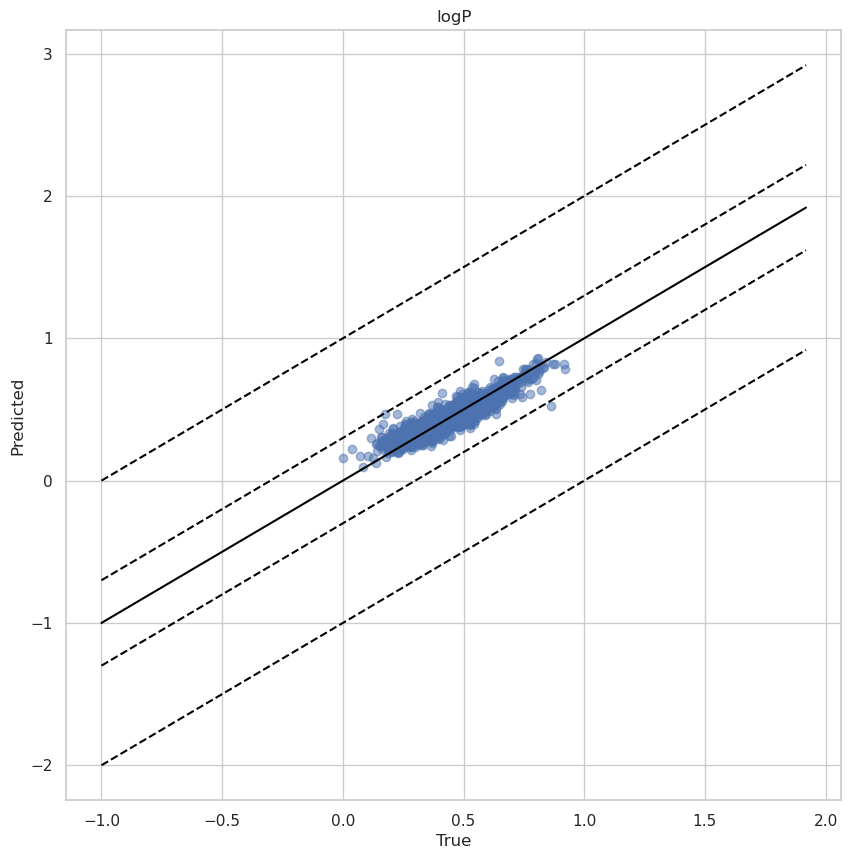

/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: Train Loss: 0.1066, Val Loss: 0.0724
Epoch 2/100: Train Loss: 0.0695, Val Loss: 0.0617
Epoch 3/100: Train Loss: 0.0626, Val Loss: 0.0570
Epoch 4/100: Train Loss: 0.0591, Val Loss: 0.0580
Epoch 5/100: Train Loss: 0.0571, Val Loss: 0.0542
Epoch 6/100: Train Loss: 0.0569, Val Loss: 0.0540
Epoch 7/100: Train Loss: 0.0575, Val Loss: 0.0594
Epoch 8/100: Train Loss: 0.0573, Val Loss: 0.0536
Epoch 9/100: Train Loss: 0.0565, Val Loss: 0.0531
Epoch 10/100: Train Loss: 0.0554, Val Loss: 0.0540
Epoch 11/100: Train Loss: 0.0565, Val Loss: 0.0631
Epoch 12/100: Train Loss: 0.0564, Val Loss: 0.0532
Epoch 13/100: Train Loss: 0.0531, Val Loss: 0.0520
Epoch 14/100: Train Loss: 0.0537, Val Loss: 0.0534
Epoch 15/100: Train Loss: 0.0552, Val Loss: 0.0530
Epoch 16/100: Train Loss: 0.0542, Val Loss: 0.0558
Epoch 17/100: Train Loss: 0.0536, Val Loss: 0.0517
Epoch 18/100: Train Loss: 0.0525, Val Loss: 0.0553
Epoch 19/100: Train Loss: 0.0537, Val Loss: 0.0511
Epoch 20/100: Train Loss: 0.0527, Val Lo

KeyboardInterrupt: 

In [35]:
#also get ST:
train_data_logp = [d for d in train_data if d.y[0][0].item() != np.nan]
val_data_logp = [d for d in val_data if d.y[0][0].item() != np.nan]
test_data_logp = [d for d in test_data if d.y[0][0].item() != np.nan]
train_loader_logp = DataLoader(train_data_logp, batch_size=64, shuffle=True)
val_loader_logp = DataLoader(val_data_logp, batch_size=64, shuffle=False)
test_loader_logp = DataLoader(test_data_logp, batch_size=64, shuffle=False)
model_logp = AttentiveFP(in_channels=23, hidden_channels=200, out_channels=1,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer_logp = torch.optim.Adam(model_logp.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model_logp, train_loader_logp, val_loader_logp, optimizer_logp, num_epochs=100, outputs=1, verbose=True)
preds_logp,ys_logp = get_preds_per_task(test_loader_logp, model_logp, 1)
kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds_logp[0],ys_logp[0])
r2 = r2_score(ys_logp[0],preds_logp[0])
pearson = pearsonr(ys_logp[0],preds_logp[0]).statistic
print('Pearson:',pearson)
print('R2:',r2)
plt.figure(figsize=(10, 10))
plt.scatter(ys_logp[0], preds_logp[0], alpha=0.5)
min_val = min(min(ys_logp[0]),min(preds_logp[0]))
max_val = max(max(ys_logp[0]),max(preds_logp[0]))
plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('logP')
print(f'kendall_tau: {kendall_tau}')
print(f'rmse_overall: {rmse_overall}')
print(f'mae_overall: {mae_overall}')
print(f'within_03_overall: {within_03_overall}')
print(f'within_1_overall: {within_1_overall}')
plt.show()

#also get ST:
train_data_vp = [d for d in train_data if d.y[0][1].item() != np.nan]
val_data_vp = [d for d in val_data if d.y[0][1].item() != np.nan]
test_data_vp = [d for d in test_data if d.y[0][1].item() != np.nan]
train_loader_vp = DataLoader(train_data_vp, batch_size=64, shuffle=True)
val_loader_vp = DataLoader(val_data_vp, batch_size=64, shuffle=False)
test_loader_vp = DataLoader(test_data_vp, batch_size=64, shuffle=False)
model_vp = AttentiveFP(in_channels=23, hidden_channels=200, out_channels=1,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer_vp = torch.optim.Adam(model_vp.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model_vp, train_loader_vp, val_loader_vp, optimizer_vp, num_epochs=100, outputs=1, verbose=True)
preds_vp,ys_vp = get_preds_per_task(test_loader_vp, model_vp, 1)
kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds_vp[0],ys_vp[0])
r2 = r2_score(ys_vp[0],preds_vp[0])
pearson = pearsonr(ys_vp[0],preds_vp[0]).statistic
print('Pearson:',pearson)
print('R2:',r2)
plt.figure(figsize=(10, 10))
plt.scatter(ys_vp[0], preds_vp[0], alpha=0.5)
min_val = min(min(ys_vp[0]),min(preds_vp[0]))
max_val = max(max(ys_vp[0]),max(preds_vp[0]))
plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('logVP')
print(f'kendall_tau: {kendall_tau}')
print(f'rmse_overall: {rmse_overall}')
print(f'mae_overall: {mae_overall}')
print(f'within_03_overall: {within_03_overall}')
print(f'within_1_overall: {within_1_overall}')
plt.show()


2774
Pearson: 0.9151460087293424
R2: 0.8370007647955766
kendall_tau: 0.7454704576978156
rmse_overall: 0.7557768377399829
mae_overall: 0.5528042331785629
within_03_overall: 0.3835616438356164
within_1_overall: 0.8366979091564528


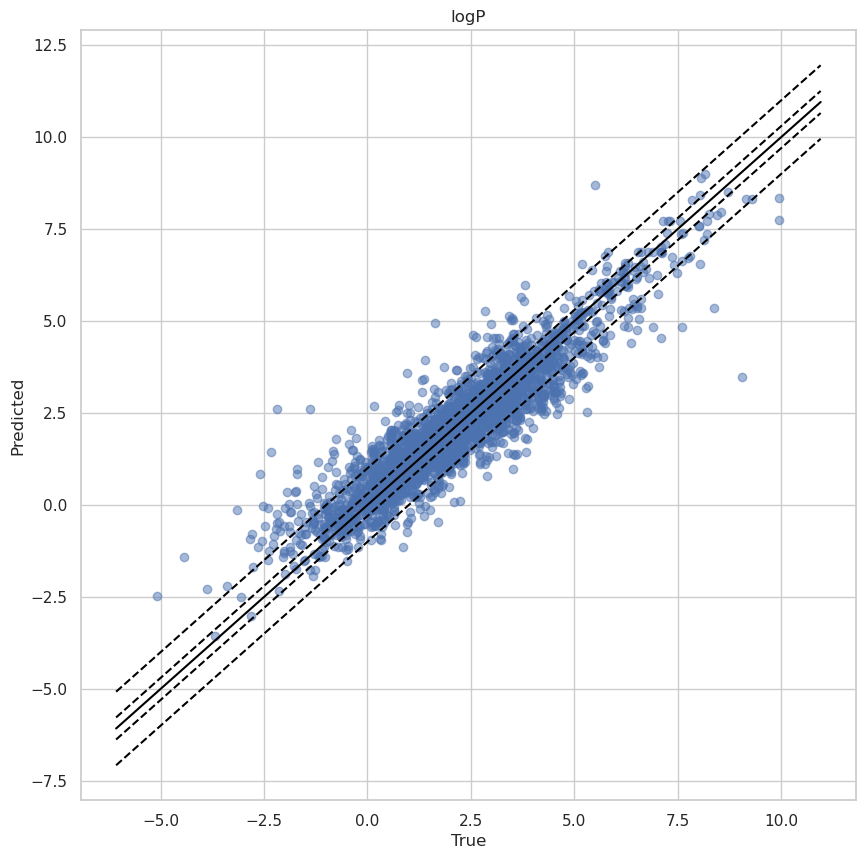

In [36]:
preds_logp,ys_logp = get_preds_per_task(test_loader_logp, model_logp, 1)
preds_logp = list(preds_logp)
ys_logp = list(ys_logp)
preds_logp[0] = min_max_scaler_logp.inverse_transform(np.array(preds_logp[0]).reshape(-1,1)).flatten()
ys_logp[0] = min_max_scaler_logp.inverse_transform(np.array(ys_logp[0]).reshape(-1,1)).flatten()
for i in range(1):
    preds_logp[i] = [float(i) for i in preds_logp[i]]
    ys_logp[i] = [float(i) for i in ys_logp[i]]
    mask = np.isnan(ys_logp[i]) == False
    preds_logp[i] = [preds_logp[i][j] for j in range(len(preds_logp[i])) if mask[j]]
    ys_logp[i] = [ys_logp[i][j] for j in range(len(ys_logp[i])) if mask[j]]
    
kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds_logp[0],ys_logp[0])
r2 = r2_score(ys_logp[0],preds_logp[0])
pearson = pearsonr(ys_logp[0],preds_logp[0]).statistic
print('Pearson:',pearson)
print('R2:',r2)
plt.figure(figsize=(10, 10))
plt.scatter(ys_logp[0], preds_logp[0], alpha=0.5)
min_val = min(min(ys_logp[0]),min(preds_logp[0]))
max_val = max(max(ys_logp[0]),max(preds_logp[0]))
plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('logP')
print(f'kendall_tau: {kendall_tau}')
print(f'rmse_overall: {rmse_overall}')
print(f'mae_overall: {mae_overall}')
print(f'within_03_overall: {within_03_overall}')
print(f'within_1_overall: {within_1_overall}')
plt.show()
